In [7]:
import pennylane as qml
from pennylane import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('MTA_Subway_Ridership_Data_Clean.csv')
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
df.set_index("Date", inplace=True)
df.rename(columns={
    "Subways: Total Estimated Ridership" : "Total Ridership",
    "Subways: % of Comparable Pre-Pandemic Day" : "Pre-Pandemic Ridership"
}, inplace=True)

Apply **min-max** scaling to normalize the dataset

In [5]:
df['Total Ridership Standardized'] = (df['Total Ridership'] - df['Total Ridership'].min()) / (df['Total Ridership'].max() - df['Total Ridership'].min())

In [6]:
df.head()

,Total Ridership,Pre-Pandemic Ridership,Total Ridership Standardized
Date,,,
2020-03-01,2212965,0.97,0.380077
2020-03-02,5329915,0.96,0.968136
2020-03-03,5481103,0.98,0.996660
2020-03-04,5498809,0.99,1.000000
2020-03-05,5496453,0.99,0.999556


In [8]:
y = df['Total Ridership Standardized'].values.astype(float)

In [9]:
N = 1 << (len(y) - 1).bit_length()
y = np.pad(y, (0, N - len(y)), mode='constant')
norm = np.linalg.norm(y)
y = y / norm
n_qubits = int(np.ceil(np.log2(N)))

In [10]:
print(f"Number of qubits: {n_qubits}")

Number of qubits: 11


In [33]:
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

Implement the **Quantum Fourier Transform** circuit

In [34]:
def QFT(wires):
    N = len(wires)
    for i in range(N):
        qml.Hadamard(wires=i)
        for j in range(i+1, N):
            qml.ControlledPhaseShift(np.pi/2**(j-i), wires=[j, i])
    for i in range(N//2):
        qml.SWAP(wires=[i, N-1-i])

In [47]:
@qml.qnode(dev)
def getAmplitude(K):
    qml.StatePrep(y, wires=range(n_qubits), normalize=True)
    QFT(range(n_qubits))
    state = qml.state()
    return state

In [49]:
def getCoeff(K):
    alpha = getAmplitude(K).tolist()[K]
    X = alpha * norm * np.sqrt(N)
    a = 2 / N * np.real(X)
    b = 2 / N * np.imag(X)
    return a, b

In [24]:
def periodToBin(period, N):
    return round(N / period)

In [25]:
weekly_bin, yearly_bin = periodToBin(7, N), periodToBin(365, N)
print(f"Weekly bin: {weekly_bin}, Yearly bin: {yearly_bin}")

Weekly bin: 293, Yearly bin: 6


In [50]:
a_weekly, b_weekly = getCoeff(weekly_bin)
a_yearly, b_yearly = getCoeff(yearly_bin)
print(f"Weekly coefficients: a={a_weekly}, b={b_weekly}")
print(f"Yearly coefficients: a={a_yearly}, b={b_yearly}")

Weekly coefficients: a=-0.04450487815864308, b=-0.08397542314989358
Yearly coefficients: a=0.030020549930181058, b=-0.013046983456393383


In [52]:
def reconstructSeason(a, b, K, N, L):
    t = np.arange(L)
    return a * np.cos(2 * np.pi * K * t / N) + b * np.sin(2 * np.pi * K * t / N)

In [58]:
weekly_curve = reconstructSeason(a_weekly, b_weekly, weekly_bin, N, len(df))
yearly_curve = reconstructSeason(a_yearly, b_yearly, yearly_bin, N, len(df))

In [59]:
seasonal_curve = weekly_curve + yearly_curve

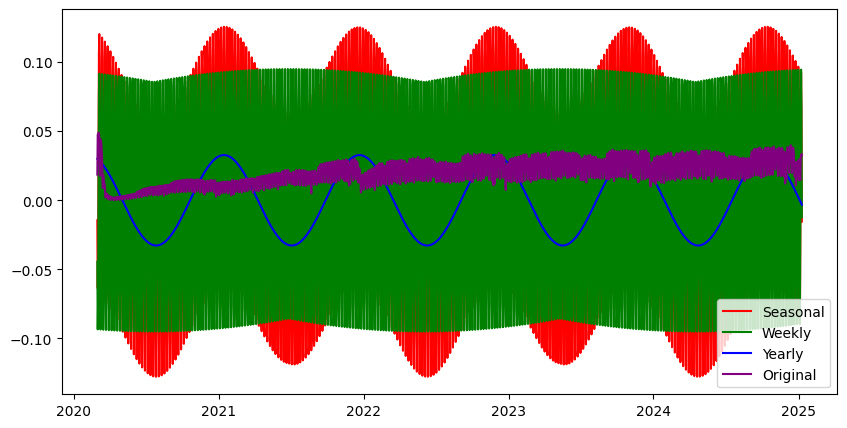

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(df.index, seasonal_curve, label='Seasonal', color='red')
plt.plot(df.index, weekly_curve, label='Weekly', color='green')
plt.plot(df.index, yearly_curve, label='Yearly', color='blue')
plt.plot(df.index, y[:len(df)], label='Original', color='purple')
plt.legend()
plt.show()